In [315]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [316]:
rdp = pd.read_excel('data.xlsx', index_col=0)

rdp.head()

,GDPPOT_20230726,GDPC1_20230727
observation_date,,
1950-01-01,2218.566586,2186.365
1950-04-01,2248.161822,2253.045
1950-07-01,2277.049682,2340.112
1950-10-01,2306.715167,2384.920
1951-01-01,2336.504742,2417.311


<Axes: xlabel='observation_date', ylabel='GDPC1_20230727'>

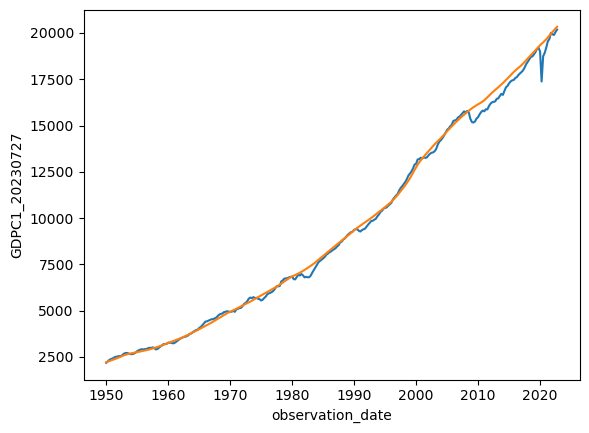

In [317]:
rdp = rdp.dropna()

sns.lineplot(data=rdp, x='observation_date', y='GDPC1_20230727')
sns.lineplot(data=rdp, x='observation_date', y='GDPPOT_20230726')

In [318]:
nrou = pd.read_csv('NROU.csv', index_col=0)

nrou.head()

,NROU
DATE,
1949-01-01,5.255053
1949-04-01,5.261516
1949-07-01,5.268013
1949-10-01,5.274564
1950-01-01,5.281182


In [319]:
unrate = pd.read_csv('UNRATE.csv', index_col=0)

unrate.head()

,UNRATE
DATE,
1948-01-01,3.7333333333333333
1948-04-01,3.6666666666666667
1948-07-01,3.7666666666666667
1948-10-01,3.8333333333333333
1949-01-01,4.6666666666666667


In [320]:
unemployment = pd.merge(left=unrate, right=nrou, left_index=True, right_index=True)

unemployment.head()

,UNRATE,NROU
DATE,,
1949-01-01,4.6666666666666667,5.255053
1949-04-01,5.8666666666666667,5.261516
1949-07-01,6.7000000000000000,5.268013
1949-10-01,6.9666666666666667,5.274564
1950-01-01,6.4000000000000000,5.281182


<Axes: xlabel='DATE', ylabel='UNRATE'>

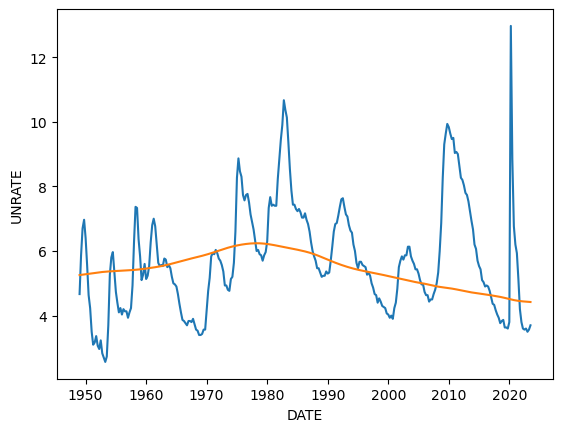

In [321]:
unemployment = unemployment[:-1]
unemployment['UNRATE'] = unemployment['UNRATE'].astype(float)
unemployment.index = pd.to_datetime(unemployment.index)

sns.lineplot(data=unemployment, x='DATE', y='UNRATE')
sns.lineplot(data=unemployment, x='DATE', y='NROU')

In [322]:
data = pd.merge(left=unemployment, right=rdp, left_index=True, right_index=True)

data.head()

,UNRATE,NROU,GDPPOT_20230726,GDPC1_20230727
1950-01-01,6.400000,5.281182,2218.566586,2186.365
1950-04-01,5.566667,5.287866,2248.161822,2253.045
1950-07-01,4.633333,5.294604,2277.049682,2340.112
1950-10-01,4.233333,5.301367,2306.715167,2384.920
1951-01-01,3.500000,5.308113,2336.504742,2417.311


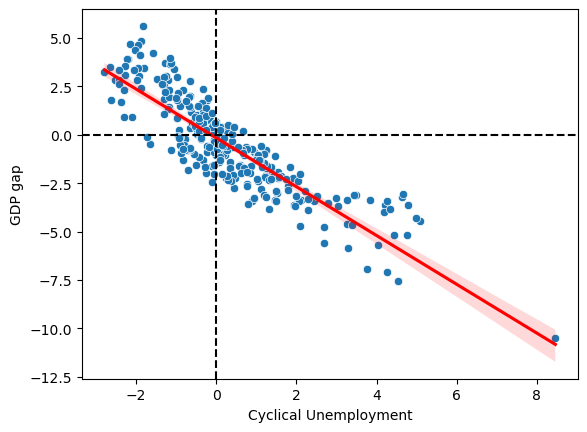

In [323]:
data['GDP gap'] = (data['GDPC1_20230727'] - data['GDPPOT_20230726']) / data['GDPPOT_20230726'] * 100

data['Cyclical Unemployment'] = data['UNRATE'] - data['NROU']

sns.scatterplot(data=data, x='Cyclical Unemployment', y='GDP gap')
sns.regplot(data=data, x='Cyclical Unemployment', y='GDP gap', scatter=False, color='r')
plt.axhline(y=0, color='k', linestyle='--')
plt.axvline(x=0, color='k', linestyle='--')
plt.show()

In [324]:
model = sm.OLS(data['GDP gap'], data['Cyclical Unemployment']).fit()

print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                GDP gap   R-squared (uncentered):                   0.772
Model:                            OLS   Adj. R-squared (uncentered):              0.772
Method:                 Least Squares   F-statistic:                              987.6
Date:                Thu, 14 Dec 2023   Prob (F-statistic):                    1.55e-95
Time:                        20:33:26   Log-Likelihood:                         -464.64
No. Observations:                 292   AIC:                                      931.3
Df Residuals:                     291   BIC:                                      935.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

In [325]:
model = sm.OLS(data['GDP gap'], sm.add_constant(data['Cyclical Unemployment'])).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                GDP gap   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     940.5
Date:                Thu, 14 Dec 2023   Prob (F-statistic):           5.19e-93
Time:                        20:33:27   Log-Likelihood:                -462.07
No. Observations:                 292   AIC:                             928.1
Df Residuals:                     290   BIC:                             935.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.15